- NVIDIA GeForce GTX 1060 6GB
- Pytorch 1.4.0
- model EfficientNet-B3
- image size 128x128
- batch size 64
- 0-folds
- 10 epochs
- augmentation rotate 4.5
- optimizer over 9000
- one cycle learning rate

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import gc
import cv2
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import torch
import warnings
warnings.filterwarnings("ignore")

from crop_resize import read_feathers

In [2]:
model_name = 'efficientnet-b3'
pretrained_model_name = './20200308_fold0_no_aug_0-1/efficientnet-b3_29.pth'
image_size = 128
batch_size = 64
random_state = 2020
n_epochs = 20
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

in_dir = Path('../input/bengaliai-cv19')
feather_dir = Path('../input/bengaliai-cv19-feather')
out_dir = Path('./20200311_cutmix')

cuda:0


In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

SEED = 2020
seed_everything(SEED)

<a id="images"></a>
# Images

In [4]:
filenames = [feather_dir/f'train_image_data_1x{image_size}x{image_size}_{i}.feather' for i in range(4)]
images = read_feathers(filenames, image_size)
print(images.shape)

(200840, 1, 128, 128)


<a id="labels"></a>
# Labels

In [5]:
train_label = pd.read_csv(in_dir/'train.csv')
labels = train_label[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
print(labels.shape)

(200840, 3)


<a id="dataset"></a>
# Dataset

In [6]:
from torch.utils.data import Dataset

class GraphemeDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.train = labels is not None
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        image = image / image.max()
        if self.transform:
            image_size = image.shape[1]
            image = self.transform(image=image[0])['image']
            image = image.reshape(-1, image_size, image_size)
        if self.train:
            label = self.labels[idx]
            return image, label[0], label[1], label[2]
        else:
            return image

In [7]:
train_dataset = GraphemeDataset(images, labels)
print(len(train_dataset))

200840


<a id="visualize"></a>
# Visualize

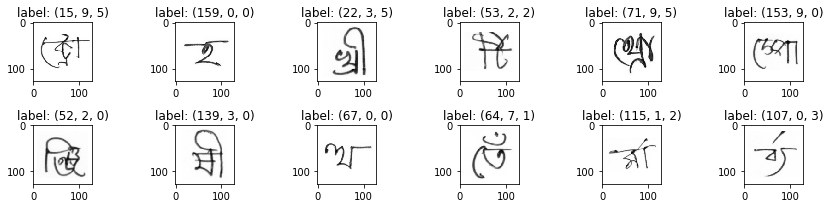

In [8]:
nrow, ncol = 2, 6
fig, axes = plt.subplots(nrow, ncol, figsize=(12, 3))
axes = axes.flatten()
for i, ax in enumerate(axes):
    image, label1, label2, label3 = train_dataset[i]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label1, label2, label3}')
plt.tight_layout()
plt.show()

<a id="dataloader"></a>
# DataLoader

In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print('train loader length', len(train_loader))

train loader length 3139


<a id="cutmix"></a>
# Cutmix

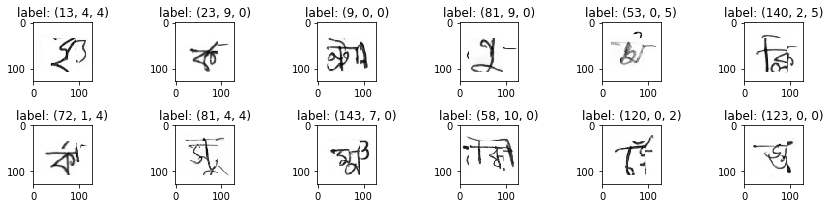

In [10]:
from mix_augmentations import cutmix

testloader = iter(train_loader)
inputs, labels1, labels2, labels3 = testloader.next()
mixed_data, _, _, _, _ = cutmix(inputs, labels1, labels2, labels3, 1.0)

nrow, ncol = 2, 6
fig, axes = plt.subplots(nrow, ncol, figsize=(12, 3))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(mixed_data[i][0], cmap='Greys')
    ax.set_title(f'label: {labels1[i].item(), labels2[i].item(), labels3[i].item()}')
plt.tight_layout()
plt.show()

<a id="model"></a> 
# Model

In [11]:
from my_efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained(model_name, in_channels=1).to(device)
model.load_state_dict(torch.load(pretrained_model_name))

Loaded pretrained weights for efficientnet-b3


<All keys matched successfully>

<a id="optimizer"></a> 
# Optimizer

In [12]:
from optimizer.ralamb import Ralamb
from optimizer.lookahead import Lookahead

def Over9000(params, alpha=0.5, k=6, *args, **kwargs):
     ralamb = Ralamb(params, *args, **kwargs)
     return Lookahead(ralamb, alpha, k)

In [13]:
optimizer =Over9000(model.parameters(), lr=2e-3, weight_decay=1e-3)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, total_steps=None, epochs=n_epochs, 
                                                steps_per_epoch=len(train_loader), pct_start=0.0, anneal_strategy='cos', 
                                                cycle_momentum=True, base_momentum=0.85, max_momentum=0.95,  div_factor=100.0)

<a id="loss"></a> 
# loss

In [14]:
from torch import nn
from mix_augmentations import mixup_criterion

criterion = nn.CrossEntropyLoss()

<a id="metrics"></a> 
# Metrics

In [15]:
from metrics import macro_recall_multi
from mix_augmentations import mix_recall_multi

<a id="train"></a> 
# Train

In [16]:
history = pd.DataFrame()

for epoch in range(n_epochs):
    
    # --- training start ---
    torch.cuda.empty_cache()
    gc.collect()
    
    running_loss1, running_loss2, running_loss3 = 0.0, 0.0, 0.0
    running_acc1, running_acc2, running_acc3 = 0.0, 0.0, 0.0
    running_recall = 0.0
    
    train_loss1, train_loss2, train_loss3 = 0.0, 0.0, 0.0
    train_acc1, train_acc2, train_acc3 = 0.0, 0.0, 0.0
    train_loss, train_acc, train_recall = 0.0, 0.0, 0.0
    
    model.train()
    
    # training loop
    for idx, (inputs, labels1, labels2, labels3) in tqdm(enumerate(train_loader), total=len(train_loader)):
        
        # to GPU
        inputs, labels1, labels2, labels3 = inputs.float().to(device), labels1.to(device), labels2.to(device), labels3.to(device)
        
        if np.random.rand() <= 0.5:
            # cutmix
            mixed_inputs, sh_labels1, sh_labels2, sh_labels3, lam = cutmix(inputs, labels1, labels2, labels3, 1.0)
            
            # to GPU
            mixed_inputs = mixed_inputs.float().to(device)
            sh_labels1, sh_labels2, sh_labels3 = sh_labels1.to(device), sh_labels2.to(device), sh_labels3.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward (on GPU)
            outputs1, outputs2, outputs3 = model(mixed_inputs)
            
            # loss
            loss1 = lam * criterion(outputs1, labels1) + (1 - lam) * criterion(outputs1, sh_labels1)
            loss2 = lam * criterion(outputs2, labels2) + (1 - lam) * criterion(outputs2, sh_labels2)
            loss3 = lam * criterion(outputs3, labels3) + (1 - lam) * criterion(outputs3, sh_labels3)
            running_loss1 += loss1.item()
            running_loss2 += loss2.item()
            running_loss3 += loss3.item()
            
            # accuracy
            running_acc1 += lam * (outputs1.argmax(1)==labels1).float().mean() + (1 - lam) * (outputs1.argmax(1)==sh_labels1).float().mean()
            running_acc2 += lam * (outputs2.argmax(1)==labels2).float().mean() + (1 - lam) * (outputs2.argmax(1)==sh_labels2).float().mean()
            running_acc3 += lam * (outputs3.argmax(1)==labels3).float().mean() + (1 - lam) * (outputs3.argmax(1)==sh_labels3).float().mean()
            
            # recall
            running_recall += mix_recall_multi(outputs1, labels1, sh_labels1, outputs2, labels2, sh_labels2, outputs3, labels3, sh_labels3, lam)
            
            # backward (on GPU)
            (0.8 * loss1 + 0.1 * loss2 + 0.1 * loss3).backward()
            
        else:
            # zero the parameter gradients
            optimizer.zero_grad()
        
            # forward (on GPU)
            outputs1, outputs2, outputs3 = model(inputs)
        
            # loss
            loss1 = criterion(outputs1, labels1)
            loss2 = criterion(outputs2, labels2)
            loss3 = criterion(outputs3, labels3)
            running_loss1 += loss1.item()
            running_loss2 += loss2.item()
            running_loss3 += loss3.item()
        
            # accuracy
            running_acc1 += (outputs1.argmax(1)==labels1).float().mean()
            running_acc2 += (outputs2.argmax(1)==labels2).float().mean()
            running_acc3 += (outputs3.argmax(1)==labels3).float().mean()
        
            # recall
            running_recall += macro_recall_multi(outputs1, labels1, outputs2, labels2, outputs3, labels3)
        
            # backward (on GPU)
            (0.8 * loss1 + 0.1 * loss2 + 0.1 * loss3).backward()
        
        # optimize
        optimizer.step()
        scheduler.step()
    
    # loss, accuracy, recall
    train_loss1 = running_loss1 / len(train_loader)
    train_loss2 = running_loss2 / len(train_loader)
    train_loss3 = running_loss3 / len(train_loader)
    train_loss = 0.5 * train_loss1 + 0.25 * train_loss2 + 0.25 * train_loss3
    train_acc1 = running_acc1 / len(train_loader)
    train_acc2 = running_acc2 / len(train_loader)
    train_acc3 = running_acc3 / len(train_loader)
    train_acc = (train_acc1 + train_acc2 + train_acc3) / 3
    train_recall = running_recall / len(train_loader)
    
    # log
    print('train epoch : {}'.format(epoch))
    print('loss   : {:.4f}, loss1 : {:.4f}, loss2 : {:.4f}, loss3 : {:.4f}'.format(train_loss, train_loss1, train_loss2, train_loss3))
    print('acc    : {:.4f}, acc1  : {:.4f}, acc2  : {:.4f}, acc3  : {:.4f}'.format(train_acc, train_acc1, train_acc2, train_acc3))
    print('recall : {:.4f}'.format(train_recall))
    
    # history
    history.loc[epoch, 'train/loss'] = train_loss
    history.loc[epoch, 'train/loss1'] = train_loss1
    history.loc[epoch, 'train/loss2'] = train_loss2
    history.loc[epoch, 'train/loss3'] = train_loss3
    history.loc[epoch, 'train/acc'] = train_acc.cpu().numpy()
    history.loc[epoch, 'train/acc1'] = train_acc1.cpu().numpy()
    history.loc[epoch, 'train/acc2'] = train_acc2.cpu().numpy()
    history.loc[epoch, 'train/acc3'] = train_acc3.cpu().numpy()
    history.loc[epoch, 'train/recall'] = train_recall
    history.loc[epoch, 'lr'] = scheduler.get_lr()[0]
    
    torch.save(model.state_dict(), out_dir/f'{model_name}_{epoch}.pth')

history.to_csv(out_dir/'history.csv')


train epoch : 0
loss   : 1.4742, loss1 : 2.0314, loss2 : 1.1639, loss3 : 0.6702
acc    : 0.7498, acc1  : 0.6777, acc2  : 0.7356, acc3  : 0.8361
recall : 0.6911



train epoch : 1
loss   : 1.3101, loss1 : 1.8724, loss2 : 0.9355, loss3 : 0.5602
acc    : 0.7379, acc1  : 0.6553, acc2  : 0.7309, acc3  : 0.8275
recall : 0.6687



train epoch : 2
loss   : 1.2594, loss1 : 1.8040, loss2 : 0.8953, loss3 : 0.5344
acc    : 0.7427, acc1  : 0.6590, acc2  : 0.7345, acc3  : 0.8345
recall : 0.6717



train epoch : 3
loss   : 1.2038, loss1 : 1.7273, loss2 : 0.8496, loss3 : 0.5111
acc    : 0.7497, acc1  : 0.6672, acc2  : 0.7413, acc3  : 0.8407
recall : 0.6784



train epoch : 4
loss   : 1.1695, loss1 : 1.6757, loss2 : 0.8270, loss3 : 0.4996
acc    : 0.7570, acc1  : 0.6765, acc2  : 0.7499, acc3  : 0.8446
recall : 0.6861



train epoch : 5
loss   : 1.1095, loss1 : 1.5942, loss2 : 0.7793, loss3 : 0.4703
acc    : 0.7683, acc1  : 0.6877, acc2  : 0.7621, acc3  : 0.8550
recall : 0.6979



train epoch : 6
loss   : 1.0761, loss1 : 1.5446, loss2 : 0.7556, loss3 : 0.4595
acc    : 0.7754, acc1  : 0.6954, acc2  : 0.7718, acc3  : 0.8590
recall : 0.7063



train epoch : 7
loss   : 1.0208, loss1 : 1.4652, loss2 : 0.7187, loss3 : 0.4342
acc    : 0.7871, acc1  : 0.7113, acc2  : 0.7832, acc3  : 0.8670
recall : 0.7210



train epoch : 8
loss   : 1.0527, loss1 : 1.5119, loss2 : 0.7399, loss3 : 0.4471
acc    : 0.7822, acc1  : 0.7037, acc2  : 0.7789, acc3  : 0.8640
recall : 0.7157



train epoch : 9
loss   : 1.0075, loss1 : 1.4466, loss2 : 0.7096, loss3 : 0.4274
acc    : 0.7915, acc1  : 0.7154, acc2  : 0.7891, acc3  : 0.8699
recall : 0.7270



train epoch : 10
loss   : 0.9792, loss1 : 1.4051, loss2 : 0.6900, loss3 : 0.4167
acc    : 0.7978, acc1  : 0.7248, acc2  : 0.7954, acc3  : 0.8734
recall : 0.7364



train epoch : 11
loss   : 0.9877, loss1 : 1.4164, loss2 : 0.6979, loss3 : 0.4204
acc    : 0.7972, acc1  : 0.7245, acc2  : 0.7944, acc3  : 0.8726
recall : 0.7372



train epoch : 12
loss   : 0.9802, loss1 : 1.4072, loss2 : 0.6908, loss3 : 0.4157
acc    : 0.7985, acc1  : 0.7253, acc2  : 0.7963, acc3  : 0.8740
recall : 0.7389



train epoch : 13
loss   : 1.0183, loss1 : 1.4631, loss2 : 0.7191, loss3 : 0.4280
acc    : 0.7918, acc1  : 0.7166, acc2  : 0.7878, acc3  : 0.8708
recall : 0.7312



train epoch : 14
loss   : 0.9942, loss1 : 1.4308, loss2 : 0.6981, loss3 : 0.4170
acc    : 0.7960, acc1  : 0.7216, acc2  : 0.7932, acc3  : 0.8733
recall : 0.7372



train epoch : 15
loss   : 0.9643, loss1 : 1.3843, loss2 : 0.6809, loss3 : 0.4078
acc    : 0.8036, acc1  : 0.7328, acc2  : 0.8009, acc3  : 0.8770
recall : 0.7469



train epoch : 16
loss   : 0.9267, loss1 : 1.3306, loss2 : 0.6540, loss3 : 0.3915
acc    : 0.8108, acc1  : 0.7426, acc2  : 0.8083, acc3  : 0.8816
recall : 0.7569



train epoch : 17
loss   : 0.9772, loss1 : 1.4058, loss2 : 0.6873, loss3 : 0.4099
acc    : 0.8014, acc1  : 0.7287, acc2  : 0.7989, acc3  : 0.8766
recall : 0.7450



train epoch : 18
loss   : 0.9433, loss1 : 1.3534, loss2 : 0.6676, loss3 : 0.3990
acc    : 0.8087, acc1  : 0.7396, acc2  : 0.8067, acc3  : 0.8799
recall : 0.7536



train epoch : 19
loss   : 0.9162, loss1 : 1.3150, loss2 : 0.6475, loss3 : 0.3871
acc    : 0.8139, acc1  : 0.7465, acc2  : 0.8116, acc3  : 0.8835
recall : 0.7607


In [17]:
history

,train/loss,train/loss1,train/loss2,train/loss3,train/acc,train/acc1,train/acc2,train/acc3,train/recall,lr
0,1.474249,2.031445,1.163856,0.670248,0.749799,0.677682,0.735647,0.836069,0.691059,9.938403e-03
1,1.310128,1.872403,0.935531,0.560175,0.737883,0.655282,0.730858,0.827508,0.668707,9.755206e-03
2,1.259416,1.804003,0.895286,0.534370,0.742665,0.658992,0.734509,0.834493,0.671682,9.454920e-03
3,1.203812,1.727305,0.849580,0.511058,0.749726,0.667206,0.741270,0.840702,0.678389,9.044939e-03
4,1.169494,1.675736,0.826956,0.499551,0.756992,0.676521,0.749854,0.844601,0.686131,8.535358e-03
5,1.109526,1.594209,0.779341,0.470347,0.768265,0.687655,0.762095,0.855044,0.697860,7.938726e-03
6,1.076078,1.544625,0.755567,0.459497,0.775388,0.695383,0.771810,0.858971,0.706324,7.269732e-03
7,1.020803,1.465152,0.718665,0.434241,0.787147,0.711253,0.783176,0.867011,0.720997,6.544850e-03
8,1.052681,1.511882,0.739883,0.447077,0.782216,0.703737,0.778938,0.863974,0.715651,5.781929e-03
9,1.007515,1.446556,0.709565,0.427384,0.791480,0.715447,0.789087,0.869905,0.726954,4.999755e-03


<a id="inference"></a> 
# Inference

In [18]:
from crop_resize import read_parquets

height = 137
width = 236
image_size = 128

filenames = [in_dir/f'test_image_data_{i}.parquet' for i in range(4)]
images = read_parquets(filenames, width, height, image_size)
test_dataset = GraphemeDataset(images)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 3078.76it/s]


In [19]:
row_id = []
target = []

model.eval()

with torch.no_grad():
    for idx, inputs in tqdm(enumerate(test_loader), total=len(test_loader)):
        inputs = inputs.float().cuda()
        outputs1, outputs2, outputs3 = model(inputs)
        p1 = outputs1.argmax(-1).view(-1).cpu()
        p2 = outputs2.argmax(-1).view(-1).cpu()
        p3 = outputs3.argmax(-1).view(-1).cpu()
        row_id += [f'Test_{idx}_grapheme_root', f'Test_{idx}_vowel_diacritic', f'Test_{idx}_consonant_diacritic']
        target += [p1.item(), p2.item(), p3.item()]

sub_df = pd.DataFrame({'row_id': row_id, 'target': target})
sub_df.to_csv(out_dir/'submission.csv', index=False)
sub_df

,row_id,target
0,Test_0_grapheme_root,3
1,Test_0_vowel_diacritic,0
2,Test_0_consonant_diacritic,0
3,Test_1_grapheme_root,93
4,Test_1_vowel_diacritic,2
5,Test_1_consonant_diacritic,0
6,Test_2_grapheme_root,19
7,Test_2_vowel_diacritic,0
8,Test_2_consonant_diacritic,0
9,Test_3_grapheme_root,115


In [20]:
exit()